In [21]:
import os
import tensorflow as tf
import keras 
import keras.layers as layers
import matplotlib.pyplot as plt
%matplotlib inline
import warnings 
# warnings.filterwarnings('ignore')
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
tf.debugging.set_log_device_placement(True)


In [2]:
# List available devices
physical_devices = tf.config.list_physical_devices('GPU')
print("GPUs Available: ", len(physical_devices))

if physical_devices:
    try:
        tf.
        print("TensorFlow is using GPU")
    except RuntimeError as e:
        print(e)
else:
    print("TensorFlow is not using GPU")


GPUs Available:  1
TensorFlow is using GPU


I0000 00:00:1727467835.799707   14634 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727467835.819556   14634 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727467835.819603   14634 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [5]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

train_dir = os.path.join(parent_dir, current_dir, 'data', 'processed', 'train')
test_dir = os.path.join(parent_dir, current_dir, 'data', 'processed', 'test')
img_size = (64, 128, 1)


In [6]:
train_ds = keras.utils.image_dataset_from_directory(
  train_dir, 
  labels='inferred',
  color_mode='grayscale',
  image_size=(img_size[0], img_size[1]),
)
valid_ds = keras.utils.image_dataset_from_directory(
  test_dir, 
  labels='inferred',
  color_mode='grayscale',
  image_size=(img_size[0], img_size[1]),
)
num_classes = len(train_ds.class_names)
target_names = valid_ds.class_names

# for image_batch, labels_batch in valid_ds:
#   for i in range(len(image_batch)):
#     plt.imshow(image_batch[i].numpy().astype("uint8")[:, :, 0], cmap='gray')
#     plt.title(f"Label: {labels_batch[i].numpy()}")
#     plt.show()

# for image_batch, labels_batch in train_ds:
#   for i in range(len(image_batch)):
#       plt.imshow(image_batch[i].numpy().astype("uint8")[:, :, 0], cmap='gray')
#       plt.title(f"Label: {labels_batch[i].numpy()}")
#       plt.show()


Found 552 files belonging to 184 classes.


I0000 00:00:1727467877.434362   14634 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727467877.434425   14634 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727467877.434442   14634 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727467877.535620   14634 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727467877.535672   14634 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-28

Found 184 files belonging to 184 classes.


In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
data_augmentation = keras.Sequential(
  [
    # layers.RandomFlip("horizontal", input_shape=img_size),
    layers.RandomRotation(0.1, input_shape=img_size),
    layers.RandomZoom(0.1),
    layers.Lambda(lambda x: 1 - x) 

  ]
)

model = keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(num_classes,activation='softmax', name="outputs")
])


In [9]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 64, 128, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 64, 128, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 128, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 16, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 16, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 184)            │        23,736 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,744 (1.32 MB)

 Trainable params: 346,488 (1.32 MB)

 Non-trainable params: 256 (1.00 KB)

In [11]:
early_stopping = keras.callbacks.EarlyStopping(
  patience=10,
  min_delta=0.001,
  restore_best_weights=True,
)

epochs = 50
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)

Epoch 1/50


2024-09-28 01:11:24.016670: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-09-28 01:11:24.432687: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1727467884.485369   14910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467884.510662   14910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467884.529923   14910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467884.548157   14910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467884.566287   14910 gpu_timer.cc:114] Skipping the delay kernel, measurement ac

 1/18 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.0000e+00 - loss: 5.5847

W0000 00:00:1727467886.287996   14910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467886.291067   14910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467886.293097   14910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467886.295891   14910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467886.297195   14910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467886.299082   14910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467886.301790   14910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467886.303270   14910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467886.306309   14910 gp

 3/18 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - accuracy: 0.0000e+00 - loss: 5.4728

W0000 00:00:1727467886.691122   14908 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467886.692104   14908 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467886.693074   14908 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467886.694346   14908 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467886.695699   14908 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467886.696732   14908 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467886.697696   14908 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467886.698694   14908 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467886.699765   14908 gp

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.0000e+00 - loss: 5.4062

W0000 00:00:1727467887.282559   14911 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467887.283815   14911 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467887.284769   14911 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467887.285752   14911 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467887.286713   14911 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467887.287659   14911 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467887.289087   14911 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467887.290169   14911 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467887.291234   14911 gp

18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.0000e+00 - loss: 5.4051 - val_accuracy: 0.0054 - val_loss: 5.2505
Epoch 2/50
 7/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 5.3547

W0000 00:00:1727467887.484084   14911 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467887.485066   14911 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467887.486056   14911 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467887.486990   14911 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467887.488015   14911 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467887.489632   14911 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467887.490574   14911 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467887.491562   14911 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727467887.492483   14911 gp

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 7.8941e-04 - loss: 5.3629 - val_accuracy: 0.0054 - val_loss: 5.2249
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0102 - loss: 5.2888 - val_accuracy: 0.0054 - val_loss: 5.2133
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0112 - loss: 5.2234 - val_accuracy: 0.0054 - val_loss: 5.2119
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0168 - loss: 5.1689 - val_accuracy: 0.0272 - val_loss: 5.1890
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0127 - loss: 5.0245 - val_accuracy: 0.0217 - val_loss: 5.1269
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0421 - loss: 4.8150 - val_accuracy: 0.0326 - val_loss: 5.0602
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0344 - loss: 4.6617 - val_accuracy: 0.0272 - val_loss: 4.9129
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0961 - loss: 4.3749 - val_accuracy: 0.0272 - val_loss

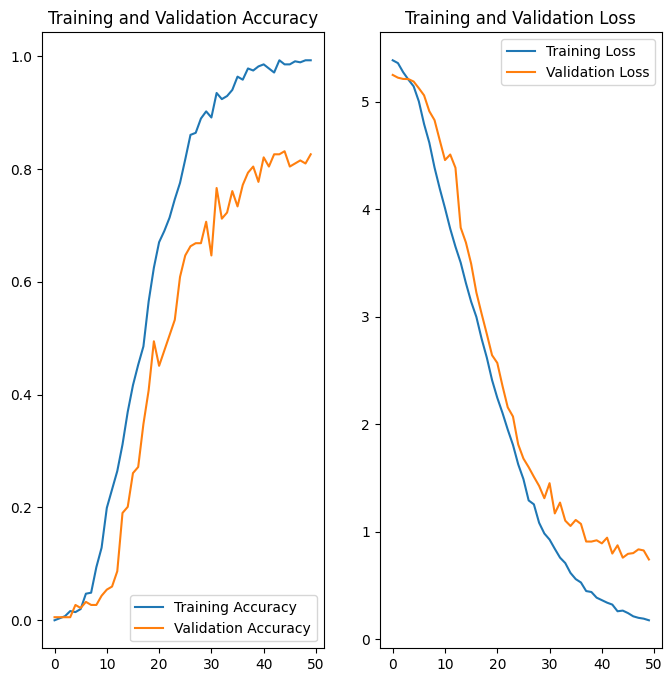

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # Ensure epochs_range matches the length of acc and val_acc

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
import numpy as np

# Get predictions on the validation set
y_pred_prob = model.predict(valid_ds)  # Predict class probabilities
y_pred = tf.argmax(y_pred_prob, axis=1).numpy()  # Convert probabilities to class labels

y_true = []
for images, labels in valid_ds:
    y_true.extend(labels.numpy())

y_true = np.array(y_true)  # Convert the list to a numpy array


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-28 01:11:45.362465: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
from sklearn.metrics import classification_report, accuracy_score

# Classification report for precision, recall, and F1-score
report = classification_report(y_true, y_pred, target_names=target_names)
print(report)

# Accuracy score
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
         100       0.00      0.00      0.00         1
         101       0.00      0.00      0.00         1
         102       0.00      0.00      0.00         1
         103       0.00      0.00      0.00         1
         104       1.00      1.00      1.00         1
         105       0.00      0.00      0.00         1
         106       1.00      1.00      1.00         1
         107       1.00      1.00      1.00         1
         108       0.50      1.00      0.67         1
         109       0.00      0.00      0.00         1
          11       1.00      1.00      1.00         1
         110       1.00      1.00      1.00         1
         111       1.00      1.00      1.00         1
         112       1.00      1.00      1.00         1
         113       1.00      1.00      1.00         1
         114       1.00    

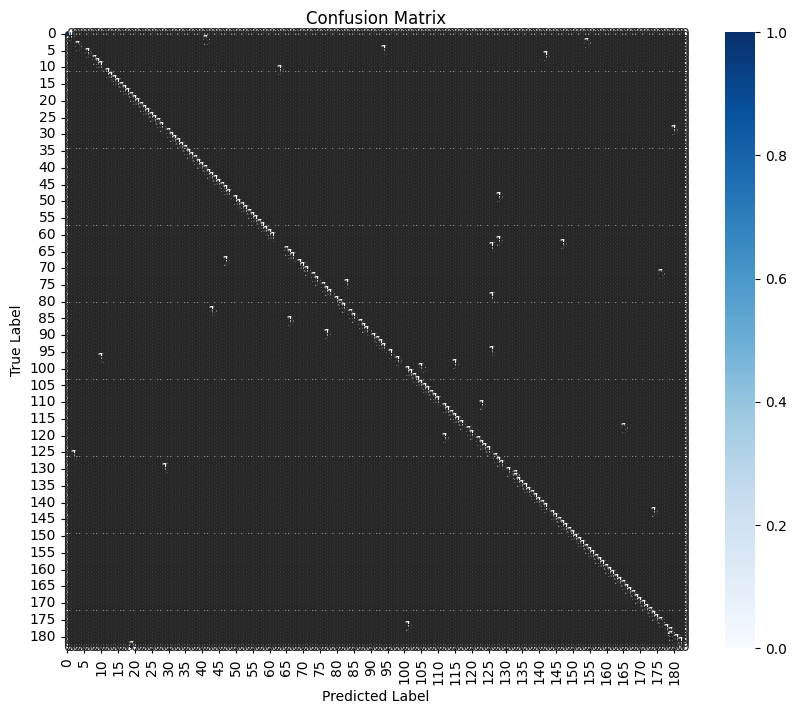

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)


# Visualize the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [16]:
base_model = tf.keras.applications.ResNet50(input_shape=(img_size[0], img_size[1], 3),include_top=False,weights='imagenet')

base_model.trainable = False  # Freeze the base model layers
model = keras.Sequential([
    layers.InputLayer(input_shape=(img_size[0], img_size[1], 1)),  # Original input shape
    layers.Conv2D(3, (3, 3), padding='same', activation='relu'),  # Convert grayscale to RGB
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Replace num_classes with the actual number of classes
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 64, 128, 3)     │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 184)            │        23,736 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,873,750 (91.07 MB)

 Trainable params: 286,038 (1.09 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [17]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs
)

Epoch 1/15


I0000 00:00:1727467925.911434   14910 service.cc:146] XLA service 0x7fe7ca0b5240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727467925.911470   14910 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-09-28 01:12:06.019512: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-28 01:12:07.631422: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5766', 168 bytes spill stores, 452 bytes spill loads

2024-09-28 01:12:08.487743: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8800', 36 bytes spill stores, 40 bytes spill loads

2024-09-28 01:12:08.926490: I external/loca

 5/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0192 - loss: 5.4916

I0000 00:00:1727467934.646254   14910 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.0148 - loss: 5.4490

2024-09-28 01:12:25.211632: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1708', 176 bytes spill stores, 176 bytes spill loads

2024-09-28 01:12:25.288223: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1708', 12 bytes spill stores, 12 bytes spill loads



18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 770ms/step - accuracy: 0.0144 - loss: 5.4370 - val_accuracy: 0.0435 - val_loss: 5.0129
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.0522 - loss: 4.8895 - val_accuracy: 0.0707 - val_loss: 4.6723
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.1456 - loss: 4.3208 - val_accuracy: 0.1467 - val_loss: 4.1232
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3158 - loss: 3.5082 - val_accuracy: 0.3261 - val_loss: 3.4215
Epoch 5/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5489 - loss: 2.6055 - val_accuracy: 0.4348 - val_loss: 2.7697
Epoch 6/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7332 - loss: 1.8523 - val_accuracy: 0.6087 - val_loss: 2.1715
Epoch 7/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8284 - loss: 1.2683 - val_accuracy: 0.5870 - val_loss: 1.9135
Epoch 8/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9016 - loss: 0.8170 - val_accuracy: 0.6685 - val_loss: 

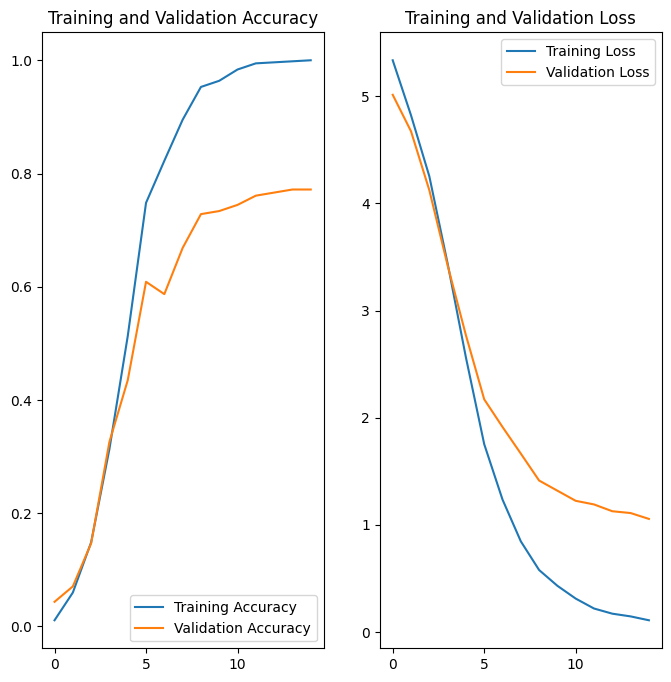

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
import numpy as np

# Get predictions on the validation set
y_pred_prob = model.predict(valid_ds)  # Predict class probabilities
y_pred = tf.argmax(y_pred_prob, axis=1).numpy()  # Convert probabilities to class labels

y_true = []
for images, labels in valid_ds:
    y_true.extend(labels.numpy())

y_true = np.array(y_true)  # Convert the list to a numpy array


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 380ms/step


2024-09-28 01:12:40.017723: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


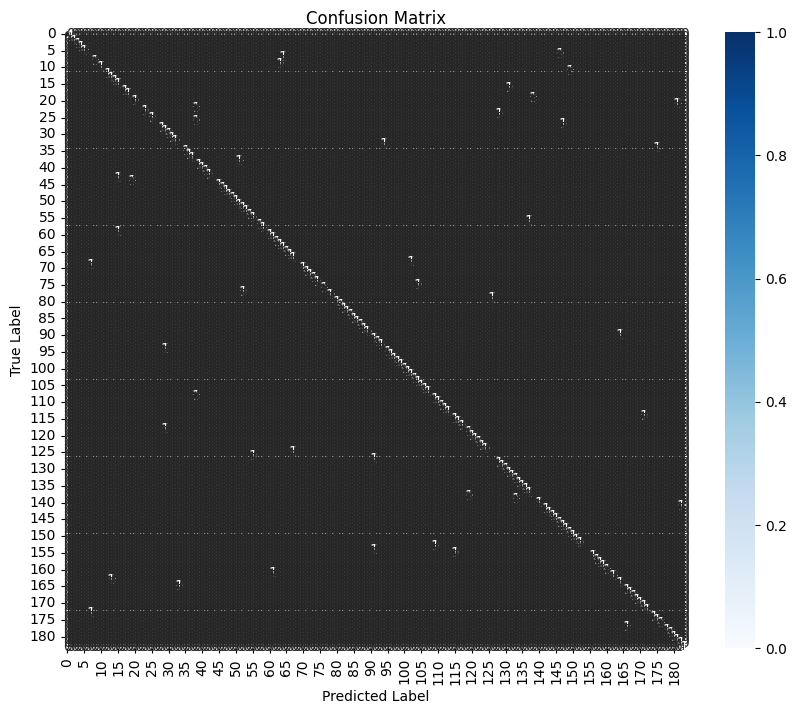

In [20]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)


# Visualize the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()